<a href="https://colab.research.google.com/github/SohamDeep2026/Tinkering-with-a-TVAR-Model/blob/main/TVAR_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Calling all libraries

import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg

<h1><b>Libraries</b></h1>


---


**pandas** is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool, built on top of the Python programming language.

**numpy** has functions for working in domain of linear algebra, fourier transform, and matrices. It finds applications in various fields like Data Science, Machine Learning, Data visualization and others.

**seaborn** is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.

**matplotlib** is a comprehensive library for creating static, animated, and interactive visualizations in Python.

**matplotlib.pyplot** is a state-based interface to matplotlib. It provides an implicit, MATLAB-like, way of plotting. It also opens figures on your screen, and acts as the figure GUI manager.

**statsmodels** is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration.

**statsmodels.tsa** contains model classes and functions that are useful for time series analysis.
Such models include univariate autoregressive models (AR), vector autoregressive models (VAR), univariate autoregressive moving average models (ARMA), Markov switching dynamic regression and autoregression.
It includes descriptive statistics for time series as well as the corresponding theoretical properties of ARMA or related processes. It also includes methods to work with autoregressive and moving average lag-polynomials.
Additionally, related statistical tests and some useful helper functions are available.

**statsmodels.api** contains cross-sectional models and methods.



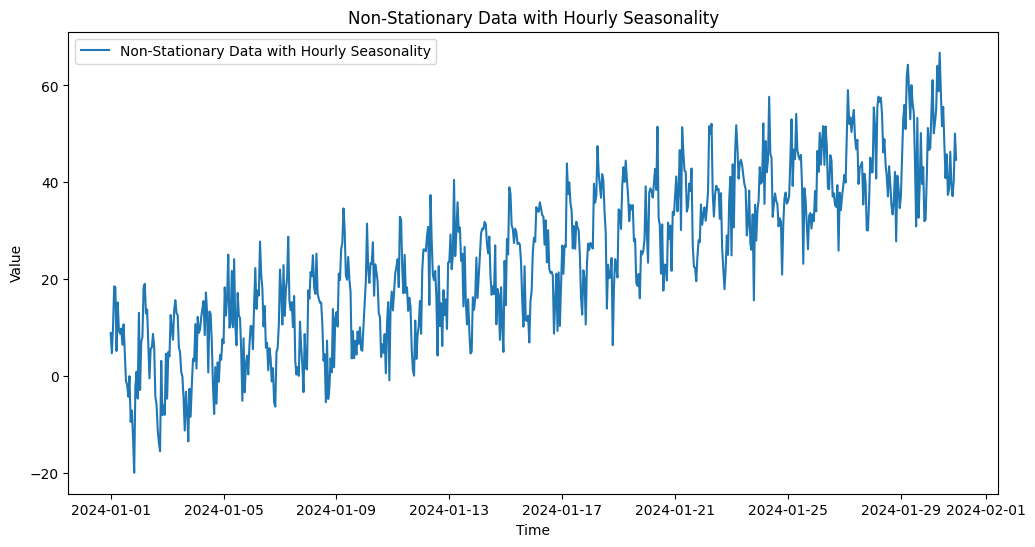

In [5]:
def random_non_stationary_data_generator(s):
    """
    The function to get randomly generated non-stationary data.

    Parameters:
        s (int): Optional. The seed value needed to generate a random number.

    Returns:
        data : DataFrame of Non-stationary data
    """

    # Set the random seed for reproducibility
    np.random.seed(s)

    # Generate time index for hourly data over 30 days
    n_days = 30
    hours_per_day = 24
    n = n_days * hours_per_day
    time_index = pd.date_range(start='2024-01-01', periods=n, freq='h')

    # Create a trend
    trend = np.linspace(0, 50, n)  # Linear trend

    # Create hourly seasonality (e.g., higher values during the day, lower at night)
    seasonality = 10 * np.sin(2 * np.pi * (time_index.hour / 24))

    # Add noise
    noise = np.random.normal(scale=5, size=n)

    # Combine trend, seasonality, and noise to create non-stationary data
    y = trend + seasonality + noise

    # Create a DataFrame to hold the data
    data = pd.DataFrame({'DateTime': time_index, 'Value': y})

    # Plot the data
    plt.figure(figsize=(12, 6))
    plt.plot(data['DateTime'], data['Value'], label='Non-Stationary Data with Hourly Seasonality')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Non-Stationary Data with Hourly Seasonality')
    plt.legend()
    plt.show()

    return data

data = random_non_stationary_data_generator(0)

<h1><b>Stationarity</h1></b>


---


A time series is stationary when mean, correlation and variance remain constant at all sections of the data. Thus, in the absence of stationary data, the applied model will have differing accuracy at different time points.

To check for the stationarity of data, various tests can be used like Augmented Dickey-Fuller (ADF) test, Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test, Phillips–Perron test, Zivot-Andrews test, Ljung Test P, Durbin-Watson (DW) test and others.

> <h4><b>ADF & KPSS Tests</B> have been used here.</h4>

Case 1: Both tests conclude that the series is not stationary - The series is not stationary

Case 2: Both tests conclude that the series is stationary - The series is stationary

Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.

Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.

In [8]:
# ADF Test
y = data['Value']

adf_res = adfuller(y)
if adf_res[1] > 0.05:
    print('The time series is not ADF Stationary')
else:
    print('The time series is ADF Stationary')

# KPSS Test

kpss_res = kpss(y)
if kpss_res[1] < 0.05:
    print('The time series is not KPSS Stationary')
else:
    print('The time series is KPSS Stationary')

The time series is not ADF Stationary
The time series is not KPSS Stationary


<ipython-input-8-198c10945676>:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_res = kpss(y)


We can verify using the ADF and KPSS tests that the generated data is Non-stationary.
However, **Time-varying Autoregression Model (TVAR) can handle Non-stationary data** because they allow the model parameters to change over time, adapting to the evolving nature of the data.

*   **Dynamic Coefficients** : TVAR models have coefficients that change over time, allowing them to capture the underlying dynamics of a non-stationary process. This flexibility means they can adapt to shifts in trends, seasonality, and other changes in the data.

*   **Localized Fitting** : While the overall data may be non-stationary, TVAR models often assume local stationarity within short time windows. By fitting autoregressive models to these smaller segments, TVAR models can handle the variations in data behavior over longer periods.

However, the Non-stationary data has been converted to Stationary data in this project to display the contrast in the heatmaps of the Autoregression (AR) coefficients generated by the TVAR model for the 2 different types of data.

<h1><b>How to remove non-stationarity?</b></h1>


---



*   **Trend**

    *   Detrending: Remove the trend component from the data. This can be achieved by fitting a regression line or using techniques like moving averages.

    *   Differencing: Take the difference between consecutive observations to remove the trend. This can be done once or multiple times until the data becomes stationary.

*   **Seasonality**

    *   Seasonal Adjustment: Use techniques such as seasonal decomposition of time series (e.g., STL decomposition) to separate the seasonal component from the data.

    *   Seasonal Differencing: Take differences between observations at the same season of different years to remove seasonality.

*   **Variance**

    *   Transformation: Apply transformations such as logarithmic, square root, or Box-Cox transformation to stabilize the variance and make it more constant over time.

*   **Autocorrelation**

    *   Differencing: Besides removing trends, differencing can also help reduce autocorrelation by eliminating dependence between consecutive observations.

    *   Autoregressive Integrated Moving Average (ARIMA): Utilize ARIMA models, which incorporate differencing to handle autocorrelation.

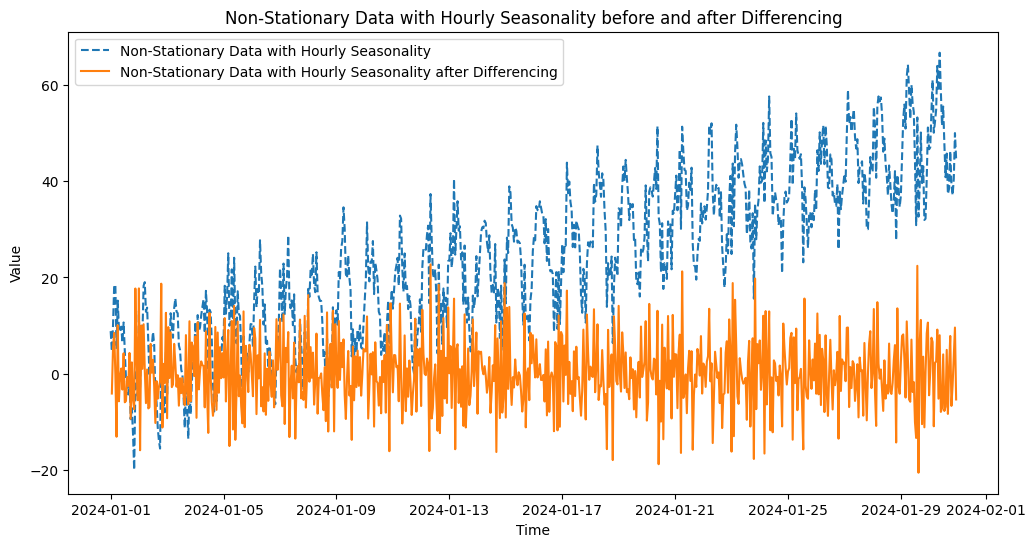

In [10]:
# Differencing to get stationary time series
data_diff = np.diff(data['Value'])

# Plot the data, and compare it to the Differenced data
plt.figure(figsize=(12, 6))
plt.plot(data['DateTime'], data['Value'], label='Non-Stationary Data with Hourly Seasonality', linestyle='--')
plt.plot(data['DateTime'][1:], data_diff, label='Non-Stationary Data with Hourly Seasonality after Differencing')
plt.title('Non-Stationary Data with Hourly Seasonality before and after Differencing')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

After differencing the Non-stationary data, the ADF and KPSS tests are used to re-check whether the data is Stationary or not.

In [11]:
# ADF Test

adf_res = adfuller(data_diff)
if adf_res[1] > 0.05:
    print('The time series is not ADF Stationary')
else:
    print('The time series is ADF Stationary')

# KPSS Test

kpss_res = kpss(data_diff)
if kpss_res[1] < 0.05:
    print('The time series is not KPSS Stationary')
else:
    print('The time series is KPSS Stationary')

The time series is ADF Stationary
The time series is KPSS Stationary


<ipython-input-11-8b1f2ce8533a>:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(data_diff)


In [14]:
stationary_data = pd.DataFrame({'DateTime': data['DateTime'][1:], 'Value': data_diff})

Therefore, we have obtained 2 time series, one Stationary and the other Non-stationary.

<h1><b>Time Varying Autoregressive Model</b></h1>


---

> **Basic Autoregressive (AR) Model**

An 𝑝-order autoregressive (AR) model can be represented as:

𝑦<sub>𝑡</sub> = 𝜙<sub>1</sub> 𝑦<sub>𝑡-1</sub> + 𝜙<sub>2</sub> 𝑦<sub>𝑡-2</sub> + ⋯ + 𝜙<sub>p</sub> 𝑦<sub>𝑡-p</sub> + 𝜖<sub>𝑡</sub>

where:

*   𝑦<sub>𝑡</sub> is the value of the time series at time 𝑡.

*   𝜙<sub>1</sub>, 𝜙<sub>2</sub>, …, 𝜙<sub>p</sub> are the autoregressive coefficients.

*   𝑝 is the order of the AR model.

*   𝜖<sub>𝑡</sub> is the white noise error term with zero mean and constant variance.

> **Time-Varying Autoregressive (TVAR) Model**

An 𝑝-order time-varying autoregressive (TVAR) model can be represented as:

𝑦<sub>𝑡</sub> = 𝜙<sub>1,t</sub> 𝑦<sub>𝑡-1</sub> + 𝜙<sub>2,t</sub> 𝑦<sub>𝑡-2</sub> + ⋯ + 𝜙<sub>p,t</sub> 𝑦<sub>𝑡-p</sub> + 𝜖<sub>𝑡</sub>

where:

*   𝑦<sub>𝑡</sub> is the value of the time series at time 𝑡.

*   𝜙<sub>i,t</sub> (for i = 1, 2, ..., p) are the time-varying autoregressive coefficients.

*   𝑝 is the order of the AR model.

*   𝜖<sub>𝑡</sub> is the white noise error term with zero mean and constant variance.

<h1><b>Estimation of Time-Varying Coefficients</b></h1>


---


There are several methods to estimate the time-varying coefficients in a TVAR model, including:


*   **Rolling Window Estimation** : Fit a separate AR model to each window of data and allow the coefficients to vary between windows.

*   **Kalman Filtering** : Use state-space models and the Kalman filter to estimate the time-varying coefficients.

*   **Smoothing Splines** : Use smoothing techniques to allow the coefficients to vary smoothly over time.


> <h4><b>Rolling Window Approach</b></h4>

In the rolling window approach, the data is divided into overlapping windows, and a separate AR model is fitted to each window. The coefficients are then allowed to vary between windows. For example, with a window size 𝑤:

𝜙<sub>1,𝑡</sub>, 𝜙<sub>2,𝑡</sub>, …, 𝜙<sub>p,𝑡</sub>

are estimated for 𝑡 = 𝑤, 𝑤+1, …, 𝑇.

> <h4><b>Kalman Filter Approach</b></h4>

Using a state-space representation, the TVAR model can be written as:

State Equation: 𝜙<sub>t+1</sub> = 𝜙<sub>𝑡</sub> + 𝜂<sub>𝑡</sub>

Measurement Equation: 𝑦<sub>𝑡</sub> = 𝜙<sub>𝑡</sub><sup>T</sup>𝑦<sub>𝑡-1</sub> + 𝜖<sub>𝑡</sub>

where 𝜙<sub>𝑡</sub> is the state vector of time-varying coefficients and 𝜂<sub>𝑡</sub> is the process noise.

The Kalman filter recursively estimates the state vector 𝜙<sub>𝑡</sub> from the observed data 𝑦<sub>𝑡</sub>.

> <h4><b>Smoothing Splines Approach</b></h4>

In this approach, the coefficients are assumed to vary smoothly over time and are modeled using spline functions. This allows for smooth transitions in the coefficients and can be estimated using smoothing techniques.

In [15]:
def tvar(y, order, window_size):
    """
    Function to fit a TVAR(3) model using rolling windows

    Parameters:
        y : 'Value' column of the time series
        order : order of the TVAR model
        window_size : size of the sliding window

    Returns:
        np.array(tvar_coefs) (numpy array) : Time-varying coefficients generated by the TVAR model

    """
    tvar_coefs = []
    for i in range(len(y) - window_size):
        window_data = y[i:i + window_size]
        model = AutoReg(window_data, lags=order, old_names=False)
        model_fit = model.fit()
        tvar_coefs.append(model_fit.params[1:])
    return np.array(tvar_coefs)

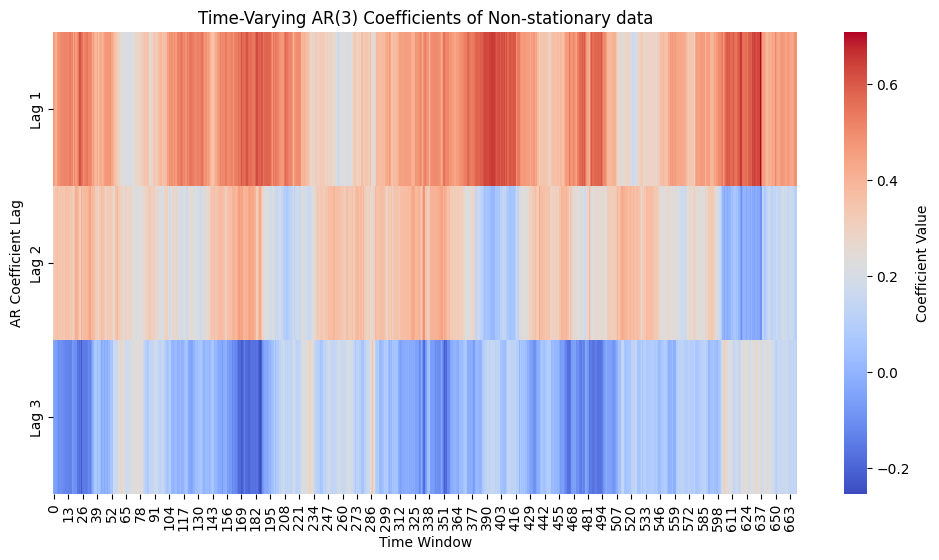

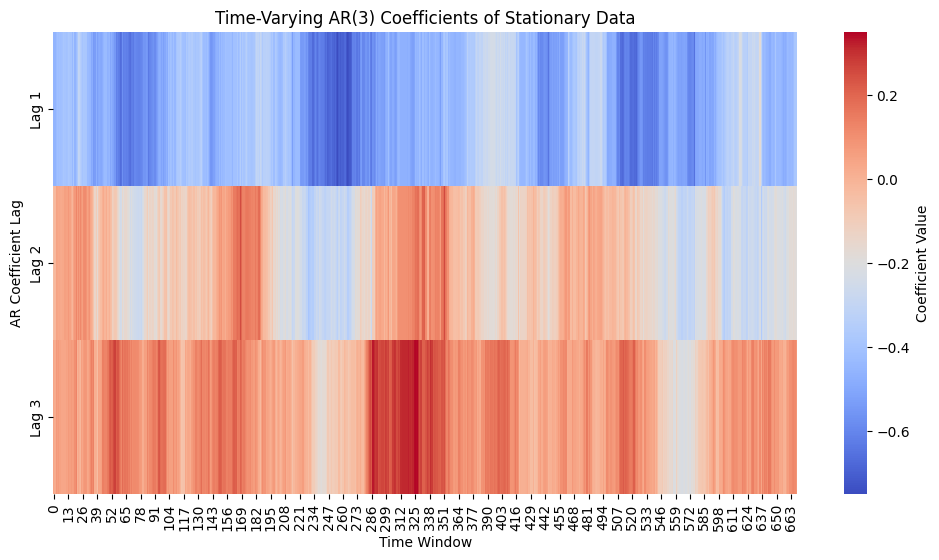

In [16]:
def st_heatmap():
    """
    Function to fit tvar model to stationary data and generate the heatmap of the AR coefficients

    Parameters: None

    Returns: None
    """
    # Fit TVAR(3) model
    order = 3
    window_size = 50
    tvar_coefs = tvar(stationary_data['Value'], order, window_size)
    tvar_coefs_data = pd.DataFrame(tvar_coefs, columns=[f'Lag {i+1}' for i in range(order)])

    # Plot the time-varying coefficients on a heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(tvar_coefs_data.T, cmap='coolwarm', cbar_kws={'label': 'Coefficient Value'})
    plt.xlabel('Time Window')
    plt.ylabel('AR Coefficient Lag')
    plt.title('Time-Varying AR(3) Coefficients of Stationary Data')

def n_st_heatmap():
    """
    Function to fit tvar model to non-stationary data and generate the heatmap of the AR coefficients

    Parameters: None

    Returns: None
    """
    # Fit TVAR(3) model
    order = 3
    window_size = 50
    tvar_coefs = tvar(data['Value'], order, window_size)
    tvar_coefs_data = pd.DataFrame(tvar_coefs, columns=[f'Lag {i+1}' for i in range(order)])

    # Plot the time-varying coefficients on a heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(tvar_coefs_data.T, cmap='coolwarm', cbar_kws={'label': 'Coefficient Value'})
    plt.xlabel('Time Window')
    plt.ylabel('AR Coefficient Lag')
    plt.title('Time-Varying AR(3) Coefficients of Non-stationary data')

n_st_heatmap()
st_heatmap()